In [1]:
!pip install gradio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 34.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 83.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.9 MB/s eta 0:00:00


In [54]:
!pip install traceback

ERROR: Could not find a version that satisfies the requirement traceback (from versions: none)
ERROR: No matching distribution found for traceback


In [1]:
# Install required packages
!pip install -q transformers timm openpyxl

#  GPU Check
import torch

print("GPU Available:", torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.benchmark = True


✅ GPU Available: False


In [2]:
import pandas as pd

# Load your vocabulary Excel file from Kaggle dataset
excel_path = "/kaggle/input/open-i-radiology-vocabulary/radiology_vocabulary_final (1).xlsx"
syn_df = pd.read_excel(excel_path, sheet_name="synonyms")

syn_df = syn_df[syn_df['Type'].isin(['A', 'D', 'S'])]

synonyms_dict = {}
for _, row in syn_df.iterrows():
    term = str(row.get("Term", "")).strip().lower()
    if not term: continue
    syn_list = [term]
    for col in syn_df.columns:
        if "Synonym" in col:
            val = row.get(col)
            if pd.notna(val):
                syn_list += [s.strip().lower() for s in str(val).split(";") if s.strip()]
    synonyms_dict[term] = list(set(syn_list))

all_terms = sorted(synonyms_dict.keys())
term_to_idx = {term: i for i, term in enumerate(all_terms)}
num_labels = len(all_terms)

print("Dictionary terms:", len(synonyms_dict))
print("Example:", list(synonyms_dict.items())[:5])

✅ Dictionary terms: 126
🔍 Example: [('abdomen', ['abdomen']), ('adipose tissue', ['localised obesity', 'lipohyperplasia', 'fat pads', 'fatty tissue hyperplasia', 'localized fat', 'adipose tissue', 'adiposis', 'localised adiposity', 'localized']), ('aorta', ['aortic structure', 'aorta', 'aortic']), ('aorta, thoracic', ['thoracic aorta', 'aorta, thoracic']), ('aortic valve', ['aortic valve'])]


In [6]:
syn_df.head()


,Term,Type,Attribute Type,Synonym,Synonym.1,Synonym.2,Synonym.3,Synonym.4,Synonym.5,Synonym.6,Synonym.7,Synonym.8,Synonym.9,Synonym.10
0,Abdomen,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Adipose Tissue,A,NaN,adiposis; localized,fatty tissue hyperplasia,localized fat,lipohyperplasia,localised adiposity,localised obesity,fat pads,NaN,NaN,NaN,NaN
2,Aorta,A,NaN,aortic,aortic structure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Aorta, Thoracic",A,NaN,thoracic aorta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aortic Valve,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
import os

# Paths
base_dir = "/kaggle/input/chest-xrays-indiana-university"
img_dir = os.path.join(base_dir, "images/images_normalized")

# Load projections and reports
proj_df = pd.read_csv(os.path.join(base_dir, "indiana_projections.csv"))
rep_df = pd.read_csv(os.path.join(base_dir, "indiana_reports.csv"))

# Handle duplicates
proj_df_clean = proj_df.sort_values("filename").drop_duplicates(subset=["uid", "projection"], keep="first")
print(len(proj_df_clean))

# Pivot to get frontal + lateral columns
proj_pivot = proj_df_clean.pivot(index="uid", columns="projection", values="filename").reset_index()
proj_pivot.columns.name = None
proj_pivot = proj_pivot.rename(columns={"Frontal": "img_frontal", "Lateral": "img_lateral"})
print(len(proj_pivot))

# Merge metadata
df = pd.merge(rep_df, proj_pivot, on="uid", how="inner")
print(len(df))

# Add full paths
df["img_frontal"] = df["img_frontal"].apply(lambda x: os.path.join(img_dir, x) if pd.notna(x) else None)
df["img_lateral"] = df["img_lateral"].apply(lambda x: os.path.join(img_dir, x) if pd.notna(x) else None)
print(len(df))

# Combine findings and impression
df["text"] = df["findings"].fillna('') + " " + df["impression"].fillna('')
# Keep samples with at least one image
df = df[df["img_frontal"].notna() | df["img_lateral"].notna()]
df = df[df["text"].str.strip() != ""]

print(" Final dataset shape:", df.shape)
print(df.head())

7239
3851
3851
3851
✅ Final dataset shape: (3826, 11)
   uid                                               MeSH  \
0    1                                             normal   
1    2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
2    3                                             normal   
3    4  Pulmonary Disease, Chronic Obstructive;Bullous...   
4    5  Osteophyte/thoracic vertebrae/multiple/small;T...   

                                            Problems  \
0                                             normal   
1                      Cardiomegaly;Pulmonary Artery   
2                                             normal   
3  Pulmonary Disease, Chronic Obstructive;Bullous...   
4                         Osteophyte;Thickening;Lung   

                                               image  \
0                          Xray Chest PA and Lateral   
1                Chest, 2 views, frontal and lateral   
2                          Xray Chest PA and Lateral   
3  PA and lateral 

In [5]:
print("Total with at least one image:", df.shape[0])
print("Samples with only frontal:", df[(df["img_frontal"].notna()) & (df["img_lateral"].isna())].shape[0])
print("Samples with only lateral:", df[(df["img_frontal"].isna()) & (df["img_lateral"].notna())].shape[0])
print("Samples with both:", df[(df["img_frontal"].notna()) & (df["img_lateral"].notna())].shape[0])
print("📊 Unique UIDs in report file:", rep_df["uid"].nunique())



Total with at least one image: 3826
Samples with only frontal: 290
Samples with only lateral: 160
Samples with both: 3376
📊 Unique UIDs in report file: 3851


In [6]:
len(df)


3826

In [7]:
from transformers import pipeline


biobert_1 = pipeline(
    "ner",
    model="alvaroalon2/biobert_diseases_ner",  # you can also try alvaroalon2/biobert_diseases_ner
    tokenizer="alvaroalon2/biobert_diseases_ner",
    aggregation_strategy="simple",
    device=0  # if using GPU
)


config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/431M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [8]:
biobert_2 = pipeline(
    "ner",
    model="judithrosell/BC5CDR_bioBERT_NER",  # you can also try alvaroalon2/biobert_diseases_ner
    tokenizer="judithrosell/BC5CDR_bioBERT_NER",
    aggregation_strategy="simple",
    device=0  # if using GPU
)


config.json:   0%|          | 0.00/917 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [14]:
import numpy as np
from tqdm import tqdm


def batch_hybrid_labeler_with_sources(texts, synonyms_dict, term_to_idx,
                                      biobert1=None, biobert2=None,
                                      batch_size=64):
    import numpy as np
    from tqdm import tqdm

    all_vectors = []
    all_sources = []
    total = len(texts)

    for i in tqdm(range(0, total, batch_size), desc="⚙️ Labeling with source tracking"):
        batch = texts[i:i+batch_size]
        vecs = np.zeros((len(batch), len(term_to_idx)), dtype=np.float32)
        sources = np.zeros((len(batch), len(term_to_idx)), dtype=np.int32)

        # Step 1: Dictionary Matching
        for j, text in enumerate(batch):
            if not isinstance(text, str): continue
            lower = text.lower()
            for term, syns in synonyms_dict.items():
                idx = term_to_idx[term]
                if term in lower or any(s in lower for s in syns):
                    vecs[j, idx] = 1
                    sources[j, idx] = 1  # 1 = Dictionary

        # Step 2a: BioBERT 1
        if biobert1:
            try:
                ner1 = biobert1(batch)
                for j, ents in enumerate(ner1):
                    for ent in ents:
                        word = ent['word'].lower().strip('#')
                        idx = term_to_idx.get(word)
                        if idx is not None:
                            vecs[j, idx] = 1
                            sources[j, idx] = 2  # 2 = BioBERT 1
            except Exception as e:
                print("BioBERT 1 failed:", e)

        # Step 2b: BioBERT 2
        if biobert2:
            try:
                ner2 = biobert2(batch)
                for j, ents in enumerate(ner2):
                    for ent in ents:
                        word = ent['word'].lower().strip('#')
                        idx = term_to_idx.get(word)
                        if idx is not None:
                            vecs[j, idx] = 1
                            sources[j, idx] = 4  # 4 = BioBERT 2
            except Exception as e:
                print("BioBERT 2 failed:", e)

        
        all_vectors.append(vecs)
        all_sources.append(sources)

    return np.vstack(all_vectors), np.vstack(all_sources)



In [15]:
auto_labels, label_sources = batch_hybrid_labeler_with_sources(
    texts=df["text"].tolist(),
    synonyms_dict=synonyms_dict,
    term_to_idx=term_to_idx,
    biobert1=biobert_1,
    biobert2=biobert_2,
    llm=llm
)


df["auto_labels"] = list(auto_labels)


⚙️ Labeling with source tracking: 100%|██████████| 60/60 [01:44<00:00,  1.75s/it]


In [16]:
flat = label_sources.flatten()
counts = {
    'Not Labeled (0)': int(np.sum(flat == 0)),
    'Dictionary (1)': int(np.sum(flat == 1)),
    'BioBERT 1 (2)': int(np.sum(flat == 2)),
    # 'LLM (3)': int(np.sum(flat == 3)),
    'BioBERT 2 (4)': int(np.sum(flat == 4)),
    'BioBERT Combined (2 or 4)': int(np.sum((flat == 2) | (flat == 4)))
}
print(counts)

{'Not Labeled (0)': 448022, 'Dictionary (1)': 28771, 'BioBERT 1 (2)': 576, 'LLM (3)': 0, 'BioBERT 2 (4)': 4707, 'BioBERT Combined (2 or 4)': 5283}


In [17]:
len(df)

3826

In [18]:
# Save DataFrame as CSV
import numpy as np
import pandas as pd

# Save dataset (CSV with all columns, incl. paths, text)
df.to_csv("final_dataset.csv", index=False)

# Save multi-hot labels and sources as .npz
np.savez_compressed("label_vectors.npz", auto_labels=auto_labels, label_sources=label_sources)

# Save the term index mapping as CSV
term_df = pd.DataFrame(list(term_to_idx.items()), columns=["term", "index"])
term_df.to_csv("term_to_index.csv", index=False)

print(" Exported: final_dataset.csv, label_vectors.npz, term_to_index.csv")


✅ Exported: final_dataset.csv, label_vectors.npz, term_to_index.csv


In [19]:
# Sanity check
import numpy as np
print(" First label vector:", df["auto_labels"].iloc[0])
print("Non-zero label indices:", np.where(df["auto_labels"].iloc[0])[0])

✅ First label vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0.]
Non-zero label indices: [ 24  33  72  80  90  91  92  97 100 103 120]


In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import AutoTokenizer, AutoModel
from PIL import Image
import torch.nn as nn
import numpy as np
import os
from tqdm import tqdm

# Dataset class
class MultiModalDataset(Dataset):
    def __init__(self, df, labels, tokenizer):
        self.texts = df["text"].tolist()
        self.front = df["img_frontal"].tolist()
        self.lat = df["img_lateral"].tolist()
        self.labels = labels
        self.tokenizer = tokenizer
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)), transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self): return len(self.texts)

    
    def __getitem__(self, idx):
        text = str(self.texts[idx]) if self.texts[idx] else ""
        tok = self.tokenizer(text, padding="max_length", truncation=True, max_length=256, return_tensors="pt")
        input_ids = tok["input_ids"].squeeze(0)
        attn_mask = tok["attention_mask"].squeeze(0)

        def load(path):
            try:
                img = Image.open(path).convert("RGB")
                return self.transform(img)
            except:
                return torch.zeros((3, 128, 128))

        img_front = load(self.front[idx])
        img_lat = load(self.lat[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return input_ids, attn_mask, img_front, img_lat, label

In [21]:
# Load encoders
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
text_encoder = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").to(DEVICE)

# Optional: Multi-GPU support for text encoder
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for text encoder")
    text_encoder = nn.DataParallel(text_encoder)


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

🚀 Using 2 GPUs for text encoder


In [22]:
class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet50(pretrained=True)
        self.base = nn.Sequential(*list(base.children())[:-1])

    def forward(self, x):
        return self.base(x).view(x.size(0), -1)

model_image = ResNetFeatureExtractor().to(DEVICE)

# Optional: Multi-GPU support for image model
if torch.cuda.device_count() > 1:
    print(f" Using {torch.cuda.device_count()} GPUs for image encoder")
    model_image = nn.DataParallel(model_image)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s] 


🚀 Using 2 GPUs for image encoder


In [23]:
# Fusion model
class FusionModel(nn.Module):
    def __init__(self, text_dim=768, img_dim=2048, hidden_dim=1024, out_dim=126):
        super().__init__()
        self.fc_text = nn.Linear(text_dim, hidden_dim)
        self.fc_img = nn.Linear(img_dim, hidden_dim)
        self.attn = nn.MultiheadAttention(hidden_dim, 4, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, out_dim)
        )

    def forward(self, text_feat, img_feat):
        x = torch.stack([self.fc_text(text_feat), self.fc_img(img_feat)], dim=1)
        attn_out, _ = self.attn(x, x, x)
        return self.mlp(attn_out.mean(dim=1))

# Instantiate and send to device
fusion_model = FusionModel(out_dim=126).to(DEVICE)

# Multi-GPU support
if torch.cuda.device_count() > 1:
    print(f" Using {torch.cuda.device_count()} GPUs for training")
    fusion_model = nn.DataParallel(fusion_model)


🚀 Using 2 GPUs for training


In [24]:
print("Is DataParallel?", isinstance(fusion_model, nn.DataParallel))


👥 Is DataParallel? True


In [25]:
!nvidia-smi


Sun Apr  6 10:20:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P0             31W /   70W |    2015MiB /  15360MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [26]:
# fusion_model = FusionModel(out_dim=num_labels).to(DEVICE)
# fusion_model.load_state_dict(torch.load("/kaggle/input/besr_model_withllm/pytorch/default/1/fusion_mode_llm.pth", map_location=DEVICE))
# fusion_model.eval()

In [27]:
from torch.utils.data import DataLoader

val_ds = MultiModalDataset(df, df["auto_labels"].tolist(), tokenizer)

In [28]:
# Feature extractors
@torch.no_grad()
def extract_text_features(input_ids, attention_mask):
    return text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state.mean(dim=1)

@torch.no_grad()
def extract_image_features(front, lat):
    return (model_image(front) + model_image(lat)) / 2

In [29]:
from sklearn.metrics import accuracy_score
import subprocess
import copy
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

# Assuming DEVICE, fusion_model, extract_text_features, and extract_image_features are defined elsewhere

def train_fusion_model(train_ds, val_ds=None, batch_size=8, epochs=15, patience=3, model_path="/kaggle/working/best_model.pth"):
    loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=batch_size, pin_memory=True, num_workers=2) if val_ds else None

    optimizer = torch.optim.AdamW(fusion_model.parameters(), lr=1e-4)
    loss_fn = nn.BCEWithLogitsLoss()
    scaler = torch.cuda.amp.GradScaler()

    best_loss = float('inf')
    best_model = None
    stop_counter = 0

    for epoch in range(epochs):
        fusion_model.train()
        total_loss = 0.0
        all_preds, all_labels = [], []

        print(f"\n Epoch {epoch+1}/{epochs}")

        for batch in tqdm(loader, desc="Training", leave=False):
            input_ids, attn_mask, front, lat, labels = [b.to(DEVICE, non_blocking=True) for b in batch]

            optimizer.zero_grad()
            text_feat = extract_text_features(input_ids, attn_mask)
            img_feat = extract_image_features(front, lat)

            with torch.cuda.amp.autocast():
                logits = fusion_model(text_feat, img_feat)
                loss = loss_fn(logits, labels.to(DEVICE))  #  fixed .to

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

            preds = (logits.sigmoid() > 0.5).float().detach().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.detach().cpu().numpy())

        acc = accuracy_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
        print(f" Train — Loss: {total_loss:.4f} | Accuracy: {acc:.4f}", end="")

        if val_loader:
            fusion_model.eval()
            val_loss = 0.0
            val_preds, val_labels = [], []

            with torch.no_grad():
                for batch in val_loader:
                    input_ids, attn_mask, front, lat, labels = [b.to(DEVICE, non_blocking=True) for b in batch]
                    text_feat = extract_text_features(input_ids, attn_mask)
                    img_feat = extract_image_features(front, lat)
                    logits = fusion_model(text_feat, img_feat)

                    val_loss += loss_fn(logits, labels.to(DEVICE)).item()
                    preds = (logits.sigmoid() > 0.5).float().cpu().numpy()
                    val_preds.extend(preds)
                    val_labels.extend(labels.cpu().numpy())

            val_acc = accuracy_score(np.array(val_labels).flatten(), np.array(val_preds).flatten())
            print(f" |  Val — Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}", end="")

            if val_loss < best_loss:
                best_loss = val_loss
                best_model = copy.deepcopy(fusion_model.state_dict())
                stop_counter = 0
                torch.save(best_model, model_path)
                print(f" |  Best model saved @ epoch {epoch+1}")
            else:
                stop_counter += 1
                print(f" |  No improvement. Patience: {stop_counter}/{patience}")

            if stop_counter >= patience:
                print(" |  Early stopping triggered!")
                print("\n  . Best Validation Loss:", best_loss)
                break
        else:
            print("")  # newline when no validation



In [32]:
from sklearn.model_selection import train_test_split

# Split the dataframe
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create dataset objects
train_ds = MultiModalDataset(train_df, train_df["auto_labels"].tolist(), tokenizer)
val_ds = MultiModalDataset(val_df, val_df["auto_labels"].tolist(), tokenizer)

# Start training with early stopping + best model save
train_fusion_model(
    train_ds,
    val_ds,
    batch_size=32,
    epochs=30,
    patience=3,
    model_path="/kaggle/working/best_model.pth"
)

<ipython-input-29-ca4d34843c77>:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



🔄 Epoch 1/30


Training:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-29-ca4d34843c77>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                         

✅ Train — Loss: 12.2633 | Accuracy: 0.9544

 | 🔍 Val — Loss: 2.9728 | Accuracy: 0.9547 | 💾 Best model saved @ epoch 1

🔄 Epoch 2/30


Training:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-29-ca4d34843c77>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                         

✅ Train — Loss: 11.3368 | Accuracy: 0.9580

 | 🔍 Val — Loss: 2.6622 | Accuracy: 0.9613 | 💾 Best model saved @ epoch 2

🔄 Epoch 3/30


Training:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-29-ca4d34843c77>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                         

✅ Train — Loss: 10.2032 | Accuracy: 0.9630

 | 🔍 Val — Loss: 2.5652 | Accuracy: 0.9626 | 💾 Best model saved @ epoch 3

🔄 Epoch 4/30


Training:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-29-ca4d34843c77>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                         

✅ Train — Loss: 9.8114 | Accuracy: 0.9643

 | 🔍 Val — Loss: 2.4532 | Accuracy: 0.9642 | 💾 Best model saved @ epoch 4

🔄 Epoch 5/30


Training:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-29-ca4d34843c77>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                         

✅ Train — Loss: 9.5595 | Accuracy: 0.9651

 | 🔍 Val — Loss: 2.4216 | Accuracy: 0.9648 | 💾 Best model saved @ epoch 5

🔄 Epoch 6/30


Training:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-29-ca4d34843c77>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                         

✅ Train — Loss: 9.3338 | Accuracy: 0.9660

 | 🔍 Val — Loss: 2.3757 | Accuracy: 0.9653 | 💾 Best model saved @ epoch 6

🔄 Epoch 7/30


Training:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-29-ca4d34843c77>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                         

✅ Train — Loss: 8.8604 | Accuracy: 0.9680

 | 🔍 Val — Loss: 2.2750 | Accuracy: 0.9667 | 💾 Best model saved @ epoch 7

🔄 Epoch 8/30


Training:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-29-ca4d34843c77>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                         

✅ Train — Loss: 8.5959 | Accuracy: 0.9688

 | 🔍 Val — Loss: 2.2148 | Accuracy: 0.9675 | 💾 Best model saved @ epoch 8

🔄 Epoch 9/30


Training:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-29-ca4d34843c77>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                         

✅ Train — Loss: 8.3361 | Accuracy: 0.9699

 | 🔍 Val — Loss: 2.1956 | Accuracy: 0.9679 | 💾 Best model saved @ epoch 9

🔄 Epoch 10/30


Training:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-29-ca4d34843c77>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                         

✅ Train — Loss: 7.9907 | Accuracy: 0.9709

 | 🔍 Val — Loss: 2.1499 | Accuracy: 0.9687 | 💾 Best model saved @ epoch 10

🔄 Epoch 11/30


Training:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-29-ca4d34843c77>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                         

✅ Train — Loss: 7.7833 | Accuracy: 0.9718

 | 🔍 Val — Loss: 2.1279 | Accuracy: 0.9692 | 💾 Best model saved @ epoch 11

🔄 Epoch 12/30


Training:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-29-ca4d34843c77>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                         

✅ Train — Loss: 7.6296 | Accuracy: 0.9721

 | 🔍 Val — Loss: 2.0565 | Accuracy: 0.9703 | 💾 Best model saved @ epoch 12

🔄 Epoch 13/30


Training:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-29-ca4d34843c77>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                         

✅ Train — Loss: 7.4023 | Accuracy: 0.9729

 | 🔍 Val — Loss: 2.0302 | Accuracy: 0.9702 | 💾 Best model saved @ epoch 13

🔄 Epoch 14/30


Training:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-29-ca4d34843c77>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                         

✅ Train — Loss: 7.2410 | Accuracy: 0.9734

 | 🔍 Val — Loss: 2.0129 | Accuracy: 0.9701 | 💾 Best model saved @ epoch 14

🔄 Epoch 15/30


Training:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-29-ca4d34843c77>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                         

✅ Train — Loss: 7.1433 | Accuracy: 0.9738

 | 🔍 Val — Loss: 2.0161 | Accuracy: 0.9705 | ⚠️ No improvement. Patience: 1/3

🔄 Epoch 16/30


Training:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-29-ca4d34843c77>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                         

✅ Train — Loss: 6.9335 | Accuracy: 0.9745

 | 🔍 Val — Loss: 1.9771 | Accuracy: 0.9714 | 💾 Best model saved @ epoch 16

🔄 Epoch 17/30


Training:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-29-ca4d34843c77>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                         

✅ Train — Loss: 6.8319 | Accuracy: 0.9747

 | 🔍 Val — Loss: 1.9788 | Accuracy: 0.9706 | ⚠️ No improvement. Patience: 1/3

🔄 Epoch 18/30


Training:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-29-ca4d34843c77>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                         

✅ Train — Loss: 6.6428 | Accuracy: 0.9754

 | 🔍 Val — Loss: 1.9840 | Accuracy: 0.9711 | ⚠️ No improvement. Patience: 2/3

🔄 Epoch 19/30


Training:   0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-29-ca4d34843c77>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                         

✅ Train — Loss: 6.5825 | Accuracy: 0.9755

 | 🔍 Val — Loss: 2.0126 | Accuracy: 0.9711 | ⚠️ No improvement. Patience: 3/3
 | ⏹️ Early stopping triggered!

🎯 Best Validation Loss: 1.9771129563450813


In [33]:
import os
os.listdir("/kaggle/working")

['term_to_index.csv',
 'label_vectors.npz',
 '.virtual_documents',
 'final_dataset.csv',
 'best_model.pth']

In [36]:
# Save the model weights
# torch.save(fusion_model.state_dict(), "/kaggle/working/fusion_mode_llm.pth")
torch.save(fusion_model.module.state_dict() if isinstance(fusion_model, nn.DataParallel) else fusion_model.state_dict(), "/kaggle/working/fusion_model.pth")
print(" Model saved to working directory.")

✅ Model saved to working directory.


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

In [39]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming DEVICE, extract_text_features, extract_image_features, and model are defined elsewhere

def evaluate_model(model, dataset, batch_size=32):
    loader = DataLoader(dataset, batch_size=batch_size, pin_memory=True, num_workers=2)
    model.eval()

    all_preds = []

    all_labels = []

    with torch.no_grad():
        for batch in tqdm(loader, desc=" Evaluating"):
            input_ids, attn_mask, front, lat, labels = [b.to(DEVICE) for b in batch]

            text_feat = extract_text_features(input_ids, attn_mask)
            img_feat = extract_image_features(front, lat)

            logits = model(text_feat, img_feat)
            preds = (logits.sigmoid() > 0.5).float().cpu().numpy()
            labels = labels.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels.flatten(), all_preds.flatten())
    precision_micro = precision_score(all_labels, all_preds, average="micro", zero_division=0)
    recall_micro = recall_score(all_labels, all_preds, average="micro", zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average="micro", zero_division=0)

    precision_macro = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    recall_macro = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    print("\n Final Evaluation:")
    print(f" Accuracy: {acc:.4f},  Precision (micro): {precision_micro:.4f},  Recall (micro): {recall_micro:.4f}, F1 Score (micro): {f1_micro:.4f}")
    print(f" Precision (macro): {precision_macro:.4f},  Recall (macro): {recall_macro:.4f}, F1 Score (macro): {f1_macro:.4f}")

In [40]:
evaluate_model(fusion_model, val_ds)

🔍 Evaluating: 100%|██████████| 24/24 [00:53<00:00,  2.21s/it]


📊 Final Evaluation:
✅ Accuracy: 0.9711, 🎯 Precision (micro): 0.8720, 📥 Recall (micro): 0.7005, 🏅 F1 Score (micro): 0.7769
🎯 Precision (macro): 0.1955, 📥 Recall (macro): 0.1223, 🏅 F1 Score (macro): 0.1363


In [41]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    hamming_loss, classification_report
)
import numpy as np
from tqdm import tqdm
import torch

def evaluate_model(model, dataset, batch_size=8, threshold=0.5):
    loader = DataLoader(dataset, batch_size=batch_size, pin_memory=True, num_workers=2)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids, attn_mask, front, lat, labels = [b.to(DEVICE) for b in batch]

            text_feat = extract_text_features(input_ids, attn_mask)
            img_feat = extract_image_features(front, lat)

            logits = model(text_feat, img_feat)
            preds = (logits.sigmoid() > threshold).float().cpu().numpy()
            labels = labels.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Standard metrics
    acc = accuracy_score(all_labels.flatten(), all_preds.flatten())
    precision_micro = precision_score(all_labels, all_preds, average="micro", zero_division=0)
    recall_micro = recall_score(all_labels, all_preds, average="micro", zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average="micro", zero_division=0)

    precision_macro = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    recall_macro = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    hamming = hamming_loss(all_labels, all_preds)

    print(f"\n Final Evaluation:")
    print(f" Accuracy           : {acc:.4f}")
    print(f" Precision (micro)  : {precision_micro:.4f}")
    print(f" Recall (micro)     : {recall_micro:.4f}")
    print(f" F1 Score (micro)   : {f1_micro:.4f}")
    print(f" Precision (macro)  : {precision_macro:.4f}")
    print(f" Recall (macro)     : {recall_macro:.4f}")
    print(f" F1 Score (macro)   : {f1_macro:.4f}")
    print(f" Hamming Loss       : {hamming:.4f}")

    return {
        "accuracy": acc,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "hamming_loss": hamming
    }

In [42]:
evaluate_model(fusion_model, val_ds, batch_size=32)

🔍 Evaluating: 100%|██████████| 24/24 [00:52<00:00,  2.20s/it]


📊 Final Evaluation:
✅ Accuracy           : 0.9711
🎯 Precision (micro)  : 0.8720
📥 Recall (micro)     : 0.7005
🏅 F1 Score (micro)   : 0.7769
🎯 Precision (macro)  : 0.1955
📥 Recall (macro)     : 0.1223
🏅 F1 Score (macro)   : 0.1363
🚨 Hamming Loss       : 0.0289


{'accuracy': 0.9711343196982883,
 'precision_micro': 0.8720115045838577,
 'recall_micro': 0.7005054151624549,
 'f1_micro': 0.7769058295964126,
 'precision_macro': 0.19547635239423464,
 'recall_macro': 0.12233300711598381,
 'f1_macro': 0.13628613958282,
 'hamming_loss': 0.028865680301711633}

In [43]:
from sklearn.metrics import classification_report
import numpy as np
import torch

# Run inference on the validation set to get predictions and true labels
y_true = []
y_pred = []

fusion_model.eval()

with torch.no_grad():
    for batch in tqdm(DataLoader(val_ds, batch_size=8, pin_memory=True, num_workers=2), desc="🔍 Predicting"):
        input_ids, attn_mask, front, lat, labels = [b.to(DEVICE) for b in batch]

        text_feat = extract_text_features(input_ids, attn_mask)
        img_feat = extract_image_features(front, lat)

        logits = fusion_model(text_feat, img_feat)
        probs = logits.sigmoid().cpu().numpy()
        predictions = (probs > 0.5).astype(int)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions)

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

🔍 Predicting: 100%|██████████| 96/96 [01:03<00:00,  1.51it/s]


In [44]:
from sklearn.metrics import classification_report

# `all_terms` must be your sorted list of label names from the dictionary
print(classification_report(y_true, y_pred, target_names=all_terms))

                                           precision    recall  f1-score   support

                                  abdomen       0.00      0.00      0.00        21
                           adipose tissue       0.00      0.00      0.00         1
                         airspace disease       1.00      0.01      0.02       100
                                    aorta       0.59      0.20      0.30        98
                          aorta, thoracic       0.00      0.00      0.00        28
                          aortic aneurysm       0.00      0.00      0.00         0
                             aortic valve       0.00      0.00      0.00         2
                                     apex       0.00      0.00      0.00        27
                                arthritis       0.00      0.00      0.00         3
                          atherosclerosis       0.00      0.00      0.00         2
                              azygos lobe       0.00      0.00      0.00         0
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [45]:
from sklearn.metrics import roc_auc_score

# Re-run model on val set to collect probabilities (sigmoid outputs)
y_true = []
fusion_model_outputs = []

fusion_model.eval()
with torch.no_grad():
    for batch in tqdm(DataLoader(val_ds, batch_size=16, pin_memory=True, num_workers=2), desc="🔍 Collecting logits"):
        input_ids, attn_mask, front, lat, labels = [b.to(DEVICE) for b in batch]

        text_feat = extract_text_features(input_ids, attn_mask)
        img_feat = extract_image_features(front, lat)

        logits = fusion_model(text_feat, img_feat)
        probs = logits.sigmoid().cpu().numpy()

        y_true.extend(labels.cpu().numpy())
        fusion_model_outputs.extend(probs)

# Convert to numpy arrays
y_true = np.array(y_true)
fusion_model_outputs = np.array(fusion_model_outputs)

🔍 Collecting logits: 100%|██████████| 48/48 [00:55<00:00,  1.15s/it]


In [46]:
from sklearn.metrics import roc_auc_score

valid_auc_indices = []
auc_scores = []

# Loop through each class and calculate ROC AUC if both 0 and 1 exist
for i in range(y_true.shape[1]):
    if len(np.unique(y_true[:, i])) == 2:
        auc = roc_auc_score(y_true[:, i], fusion_model_outputs[:, i])
        auc_scores.append(auc)
        valid_auc_indices.append(i)

# Map back to label names
label_aucs = [(all_terms[i], auc_scores[j]) for j, i in enumerate(valid_auc_indices)]

# Sort and print top scores
label_aucs.sort(key=lambda x: x[1], reverse=True)
print(" Top ROC AUC per class:")
for term, auc in label_aucs[:10]:
    print(f"{term:35s} : {auc:.4f}")

📈 Top ROC AUC per class:
shift                               : 0.9935
pericardial effusion                : 0.9881
atherosclerosis                     : 0.9810
pulmonary fibrosis                  : 0.9804
pleural effusion                    : 0.9751
spine                               : 0.9747
pulmonary alveoli                   : 0.9699
pneumothorax                        : 0.9699
nipple shadow                       : 0.9686
pleura                              : 0.9658


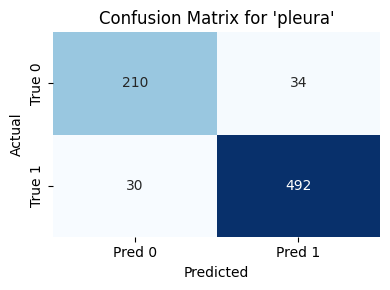

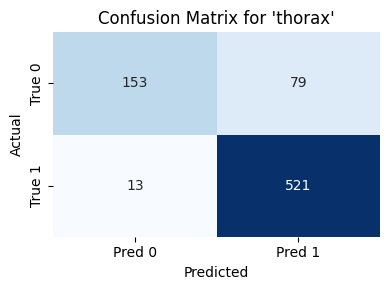

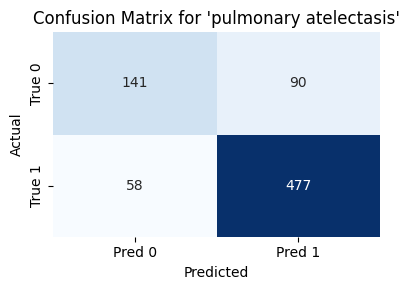

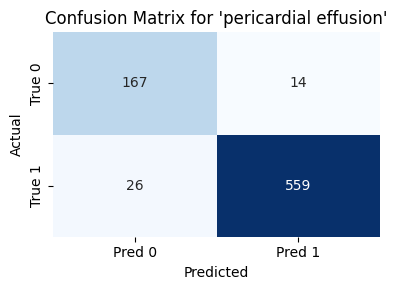

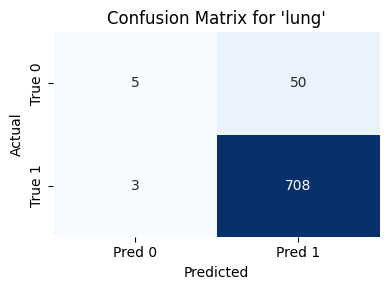

In [47]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Threshold model outputs to get binary predictions
y_pred = (fusion_model_outputs > 0.5).astype(int)

# 2. Compute the multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_true, y_pred)

# 3. Visualize confusion matrix for selected labels (e.g., top 5 by frequency)
top_indices = np.argsort(np.sum(y_true, axis=0))[-5:]  # top 5 most frequent

for idx in top_indices:
    cm = mcm[idx]
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"])
    plt.title(f"Confusion Matrix for '{all_terms[idx]}'")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

In [ ]:
import gradio as gr
import torch
import traceback
import pandas as pd
from torchvision import transforms
from PIL import Image

#  Same preprocessor used during training
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

def predict_gui(text, image):
    try:
        if not text and not image:
            return "No input provided", [["-", "-", "-", "-"]]
        
        # Tokenize text
        inputs = tokenizer(text or "", padding="max_length", truncation=True, max_length=256, return_tensors="pt")
        input_ids = inputs["input_ids"].to(DEVICE)
        attn_mask = inputs["attention_mask"].to(DEVICE)

        # Extract text features
        text_feat = extract_text_features(input_ids, attn_mask)

        # Extract image features
        if image:
            if isinstance(image, Image.Image):
                img = image.convert("RGB")
            else:
                img = Image.open(image).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(DEVICE)
            img_feat = model_image(img_tensor)
        else:
            img_feat = torch.zeros((1, 2048)).to(DEVICE)

        # Predict
        with torch.no_grad():
            logits = fusion_model(text_feat, img_feat)
            probs = torch.sigmoid(logits).squeeze().cpu().numpy()

        # Map predictions
        pred_indices = np.where(probs > 0.5)[0]
        pred_terms = [all_terms[i] for i in pred_indices]
        confidences = [probs[i] for i in pred_indices]

        # Optional term type lookup (can customize)
        def get_type(term):
            if "effusion" in term.lower(): return "Condition"
            elif "vertebrae" in term.lower(): return "Anatomy"
            elif "lung" in term.lower(): return "Organ"
            elif "consolidation" in term.lower(): return "Finding"
            else: return "Entity"

        # Prepare table data
        table_data = []
        for i, term in enumerate(pred_terms):
            table_data.append([
                term,
                get_type(term),
                f"{confidences[i]:.2f}",
                "Fusion Model"
            ])

        # Highlight in text
        highlighted = text
        for term in sorted(pred_terms, key=len, reverse=True):
            if term.lower() in highlighted.lower():
                highlighted = highlighted.replace(term, f"<mark>{term}</mark>")

        return highlighted, table_data

    except Exception as e:
        print("🚨 Error in predict_gui:", e)
        traceback.print_exc()
        return "Prediction Failed", [["-", "-", "-", "-"]]

#  Gradio Interface
interface = gr.Interface(
    fn=predict_gui,
    inputs=[
        gr.Textbox(label="📋 Radiology Report", lines=5, placeholder="Enter radiology findings or impression..."),
        gr.Image(type="pil", label="🩻 X-ray Image (Optional)")
    ],
    outputs=[
        gr.HTML(label="Highlighted Report"),
        gr.Dataframe(
            headers=["Term", "Type", "Confidence", "Source"],
            datatype=["str", "str", "number", "str"],
            label="📑 Predicted Biomedical Terms"
        )
    ],
    title="🧠 IntegraBNER - Multimodal Biomedical Named Entity Recognition",
    description="Upload a radiology report and/or X-ray image. IntegraBNER highlights relevant biomedical terms using a fusion model.",
    allow_flagging="never",
    theme="soft"
)

interface.launch(debug=True)


/usr/local/lib/python3.10/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://7f5a81ae0b84aca225.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://7f5a81ae0b84aca225.gradio.live


In [1]:
import pandas as pd
import json

# Load your CSV (update the path if needed)
df = pd.read_csv("/kaggle/input/labels/term_to_index.csv")

# Convert to list of terms (assuming there's a column like 'term' or similar)
terms = df['term'].tolist()  # Replace 'term' with the actual column name if different

# Save as labels.json
with open("labels.json", "w") as f:
    json.dump(terms, f, indent=2)

print(f"✅ Saved {len(terms)} labels to labels.json")


✅ Saved 126 labels to labels.json
